In [1]:
# grab directory root
import sys
sys.path.append("../")

In [2]:
from dinov3.eval.tSNE import compute_tsne_and_plot, extract_embeddings
from dinov3.data.datasets import NCells
from dinov3.models.backbone_loader import load_backbone
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/students/.netrc
wandb: Currently logged in as: hannes-leonh (ml4rg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/home/students/.local/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:4807: UserWarning: No device id is provided via `init_process_group` or `barrier `. Using the current device set by the user. 
  warnings.warn(  # warn only once
[rank0]:[W821 13:48:53.604973503 ProcessGroupNCCL.cpp:5023] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 as device used by this process is currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect. You can specify device_id in init_process_group() to force use of a particular device.


In [3]:
from torchvision import transforms

# defaul transform used in dinv3
def make_transform(resize_size: int | list[int] = 768):
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize((resize_size, resize_size), antialias=True)
    normalize = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return transforms.Compose([to_tensor, resize, normalize])

dataset = NCells(
    root="/home/students/code/helmholtzSS25/Hannes/dinov3playground/manifest_train_fixed.csv.gz",
    split=NCells.Split.TRAIN,
    transform=make_transform(), 
    target_transform=None,
)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [4]:
model = load_backbone(
    config_file="/home/students/code/helmholtzSS25/Hannes/dinov3playground/outputs-autumn-grass-27/config.yaml",
    pretrained_weights="/home/students/code/helmholtzSS25/Hannes/dinov3playground/outputs-autumn-grass-27/ckpt/123749",
    output_dir="/home/students/code/helmholtzSS25/Hannes/dinov3playground/outputs-autumn-grass-27"
)

Materializing model parameters on cuda
Model loaded on 123750 start iteration
Model backbone architecture: 
 DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        

In [5]:
target_size = 224
batch_size = 64
num_workers = 6
embeddings, labels = extract_embeddings(
    model=model,
    dataset=test_dataset,
    device=DEVICE,
    batch_size=batch_size,
    num_workers=num_workers,
    target_size=target_size,
)

Starting embedding extraction. Batches: 6725


batches: 100%|██████████| 6725/6725 [08:05<00:00, 13.85it/s]


In [6]:
set(labels)

{'Adrenal_gland__Connective',
 'Adrenal_gland__Epithelial',
 'Adrenal_gland__Inflammatory',
 'Adrenal_gland__Neoplastic',
 'Big',
 'Bile-duct__Connective',
 'Bile-duct__Dead',
 'Bile-duct__Epithelial',
 'Bile-duct__Inflammatory',
 'Bile-duct__Neoplastic',
 'Bladder__Connective',
 'Bladder__Epithelial',
 'Bladder__Inflammatory',
 'Bladder__Neoplastic',
 'Breast__Connective',
 'Breast__Epithelial',
 'Breast__Inflammatory',
 'Breast__Neoplastic',
 'CD20',
 'CD3',
 'CD34',
 'CD38',
 'CD68',
 'CDK4',
 'Cell',
 'Cervix__Connective',
 'Cervix__Dead',
 'Cervix__Epithelial',
 'Cervix__Inflammatory',
 'Cervix__Neoplastic',
 'Colon__Connective',
 'Colon__Dead',
 'Colon__Epithelial',
 'Colon__Inflammatory',
 'Colon__Neoplastic',
 'Control__B',
 'Control__DC',
 'Control__M0',
 'Control__Negs',
 'Control__Nk',
 'Control__T0',
 'Control__T4',
 'Control__T8',
 'D2',
 'Debris',
 'DyingCell',
 'Epithelial',
 'Esophagus__Connective',
 'Esophagus__Dead',
 'Esophagus__Epithelial',
 'Esophagus__Inflammatory

/home/students/code/helmholtzSS25/Hannes/dinov3playground/notebooks/../dinov3/eval/tSNE.py:156: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved TSNE to tsne_test_split.png


array([[  32.42587  ,   88.93058  ],
       [   3.1224654, -149.27457  ],
       [   2.578127 ,  204.88937  ],
       ...,
       [  -3.1720276,   30.027397 ],
       [ 107.22286  ,  -10.859062 ],
       [ -64.75504  ,    6.137978 ]], shape=(430351, 2), dtype=float32)

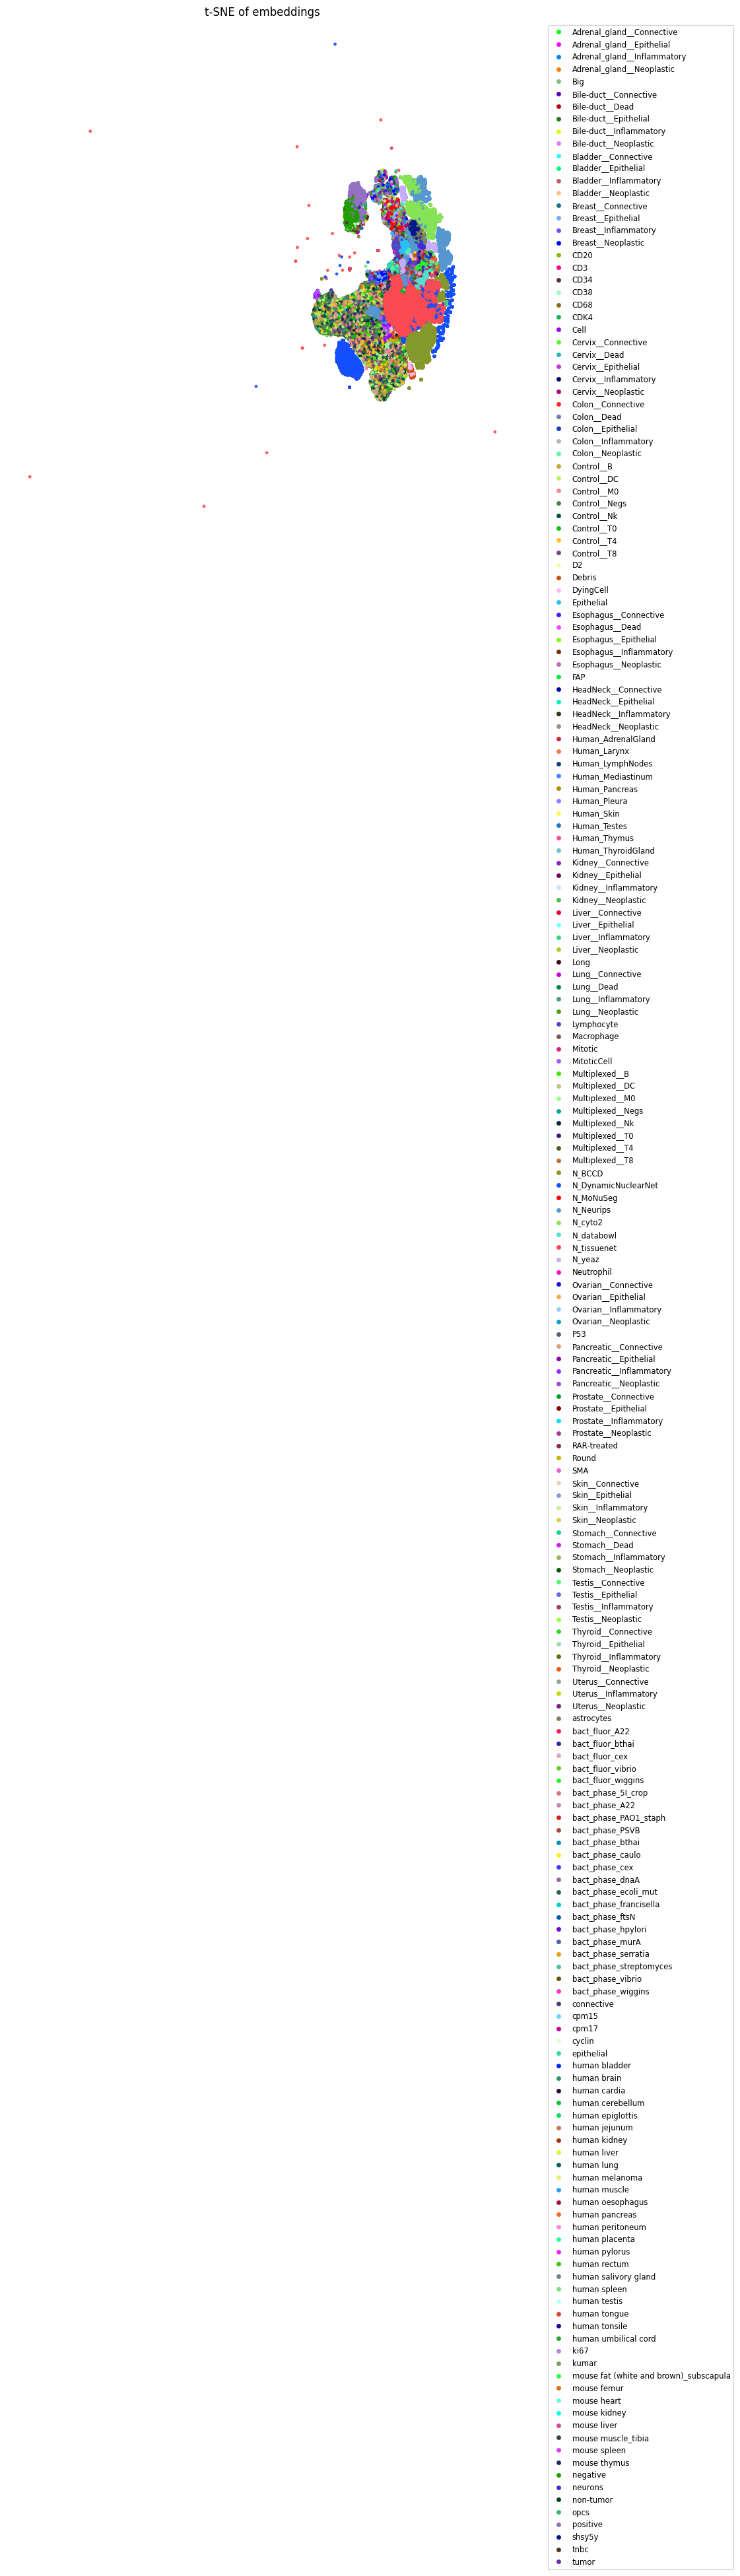

In [7]:
from dinov3.eval.tSNE import compute_tsne_and_plot

compute_tsne_and_plot(embeddings, labels, out_path="tsne_test_split.png", pca_dim=50)

In [28]:
from dinov3.eval.simpleKNN import evaluate_simple_knn
import numpy as np

# Choose evaluation size:
EVAL_SIZE = embeddings.shape[0]
# sample without replacement
rng = np.random.default_rng(0)
N = embeddings.shape[0]
if EVAL_SIZE < N:
    idx = rng.choice(N, size=EVAL_SIZE, replace=False)
    emb_sample = embeddings[idx]
    lab_sample = [labels[i] for i in idx]
else:
    emb_sample = embeddings
    lab_sample = labels

results = evaluate_simple_knn(emb_sample, lab_sample, k_list=[1,5,10], metric='cosine', sample_size=None)
print("SKLEARN RESULTS:", results)


SKLEARN RESULTS: {1: {'top1_acc': np.float64(0.6528066624685431), 'precision@k': 0.6528066624685431, 'recall@k': 0.00017348065095103198, 'mAP': 0.681818318182567}, 5: {'top1_acc': np.float64(0.6528066624685431), 'precision@k': 0.6134694702696168, 'recall@k': 0.000771453065843437, 'mAP': 0.681818318182567}, 10: {'top1_acc': np.float64(0.6528066624685431), 'precision@k': 0.5621088367402423, 'recall@k': 0.00143899185375557, 'mAP': 0.681818318182567}}


In [ ]:
# Note for 50k samples
import json
print(json.dumps(results, sort_keys=True, indent=4))

{
    "1": {
        "mAP": 0.6772142097946585,
        "precision@k": 0.50076,
        "recall@k": 0.0012688923974982194,
        "top1_acc": 0.50076
    },
    "5": {
        "mAP": 0.6772142097946585,
        "precision@k": 0.580144,
        "recall@k": 0.005156251198017758,
        "top1_acc": 0.50076
    },
    "10": {
        "mAP": 0.6772142097946585,
        "precision@k": 0.579858,
        "recall@k": 0.00908231995189566,
        "top1_acc": 0.50076
    }
}


In [29]:
# Note for 430351 (20% of dataset) samples
import json
print(json.dumps(results, sort_keys=True, indent=4))

{
    "1": {
        "mAP": 0.681818318182567,
        "precision@k": 0.6528066624685431,
        "recall@k": 0.00017348065095103198,
        "top1_acc": 0.6528066624685431
    },
    "5": {
        "mAP": 0.681818318182567,
        "precision@k": 0.6134694702696168,
        "recall@k": 0.000771453065843437,
        "top1_acc": 0.6528066624685431
    },
    "10": {
        "mAP": 0.681818318182567,
        "precision@k": 0.5621088367402423,
        "recall@k": 0.00143899185375557,
        "top1_acc": 0.6528066624685431
    }
}


In [ ]:
#db scan at end of epoch in three different hierachies
# positive and negative samples
# triplet loss